# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [36]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab

import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In Colab you can run this cell to download the dataset. If you would like to download the dataset to your PC visit the url and the dataset will automatically download as a zip 

WARNING: Downloading the dataset will take a long time

In [38]:
# Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

### Get the data

In [39]:
# General parameters
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
ROOT = r'C:\Users\itber\Documents\datasets\shapenetcore_partanno_segmentation_benchmark_v0'

# model hyperparameters
GLOBAL_FEATS = 4096

# training hyperparameters
BATCH_SIZE = 16
EPOCHS = 25
LR = 0.01

Helpers for our dataset

In [40]:
# get class - label mappings
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}
                
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [56]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset

# train Dataset & DataLoader
train_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='train', classification=True, 
                                class_choice=None, image=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation Dataset & DataLoader
valid_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='valid', classification=True, 
                                class_choice=None, image=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# test Dataset & DataLoader (segmentation version for display)
test_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', classification=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [42]:
points, targets = next(iter(train_dataloader))
points.shape

torch.Size([16, 2500, 3])

In [43]:
from point_net import PointNetClassHead

classifier = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([16, 16])


In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

### Begin Training Model

In [46]:
import torch.optim as optim

optimizer = optim.Adam(classifier.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [6]:
# stuff for training
num_train_batch = len(train_dataset)/BATCH_SIZE 
num_valid_batch = len(valid_dataset)/BATCH_SIZE 

# lists to store metrics
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

# TRAIN ON EPOCHS
for epoch in range(1, EPOCHS):

    # place model in training mode
    classifier = classifier.train()
    _train_loss = []
    _train_accuracy = []
    for i, (points, targets) in enumerate(train_dataloader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)
        
        # compute regularization term to enforce orthogonality on the feature Transformation
        I = torch.eye(64).unsqueeze(0).repeat(A.shape[0], 1, 1).to(device)
        reg = torch.linalg.norm(I - torch.bmm(A, A.transpose(2, 1)))

        # get loss and perform backprop
        loss = criterion(preds, targets) + reg
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)

        if i % 100 == 0:
            print('\t [%d: %d/%d] train loss: %f accuracy: %f' \
                  % (epoch, i, num_train_batch, loss.item(), accuracy))
        
    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]} - Train Accuracy: {train_accuracy[-1]}')

    # pause to cool down
    time.sleep(4)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        _valid_loss = []
        _valid_accuracy = []
        for i, (points, targets) in enumerate(valid_dataloader, 0):

            points = points.transpose(2, 1).to(device)
            targets = targets.squeeze().to(device)

            preds, _, _ = classifier(points)
            loss = criterion(preds, targets)

            pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct.item()/float(BATCH_SIZE)

            # update epoch loss and accuracy
            _valid_loss.append(loss.item())
            _valid_accuracy.append(accuracy)

            if i % 100 == 0:
                print('\t [%d: %d/%d] %s loss: %f accuracy: %f' \
                      % (epoch, i, num_valid_batch, 'validation', loss.item(), accuracy))
        
        valid_loss.append(np.mean(_valid_loss))
        valid_accuracy.append(np.mean(_valid_accuracy))
        print(f'Epoch: {epoch} - Validation Loss: {valid_loss[-1]} - Validation Accuracy: {valid_accuracy[-1]}')

        # pause to cool down
        time.sleep(4)

    torch.save(classifier.state_dict(), 'cls/cls_model_%d.pth' % epoch)

274.0

### Test Model performance

In [47]:
MODEL_PATH = 'cls/cls_model_4.pth'

classifier = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(device)
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval();

In [124]:
from random import randrange

# torch.cuda.empty_cache() # release GPU memory
# points, seg = next(iter(test_dataloader))

# get random sample from test data 
random_idx = randrange(len(test_dataset))
points, seg = test_dataset.__getitem__(random_idx)

with torch.no_grad():
    points = points.unsqueeze(0).transpose(2, 1).to(device)
    targets = targets.squeeze().to(device)

    preds, _, _ = classifier(points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 

Inspect the results

In [125]:
pred_class = list(classes_dict.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Chair, with probability: 0.920298159122467


Visualize the probabilities

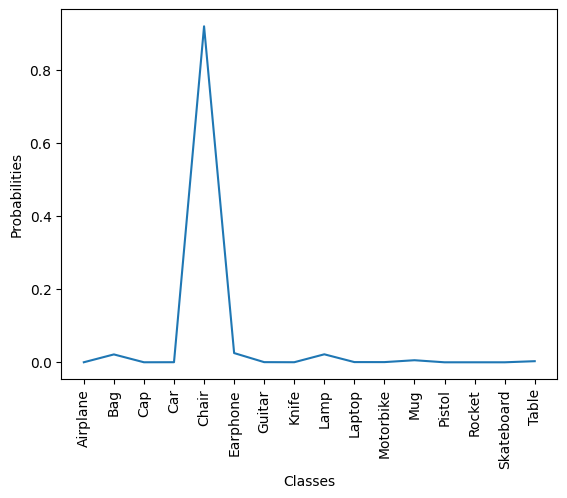

In [126]:
plt.xticks(list(classes_dict.values()), list(classes_dict.keys()), rotation=90)
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.plot(list(classes_dict.values()), preds[0]);

In [127]:
cloud = o3.geometry.PointCloud()
cloud.points = o3.utility.Vector3dVector(points[0, :, :].T)
cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))
draw(cloud)

WebVisualizer(window_uid='window_2')